Found 1153 images belonging to 2 classes.
Found 287 images belonging to 2 classes.
Epoch 1/30
73/73 [==============================] - 29s 336ms/step - loss: 0.6883 - accuracy: 0.5750 - val_loss: 0.6675 - val_accuracy: 0.5819
Epoch 2/30
73/73 [==============================] - 26s 356ms/step - loss: 0.6782 - accuracy: 0.5768 - val_loss: 0.6618 - val_accuracy: 0.6028
Epoch 3/30
73/73 [==============================] - 27s 368ms/step - loss: 0.6681 - accuracy: 0.5750 - val_loss: 0.6692 - val_accuracy: 0.6028
Epoch 4/30
73/73 [==============================] - 26s 361ms/step - loss: 0.6613 - accuracy: 0.5950 - val_loss: 0.6748 - val_accuracy: 0.5993
Epoch 5/30
73/73 [==============================] - 26s 349ms/step - loss: 0.6414 - accuracy: 0.6288 - val_loss: 0.6629 - val_accuracy: 0.5679
Epoch 6/30
73/73 [==============================] - 26s 354ms/step - loss: 0.6450 - accuracy: 0.6080 - val_loss: 0.6608 - val_accuracy: 0.6098
Epoch 7/30
73/73 [==============================] - 49s 676

C:\Users\KIIT\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


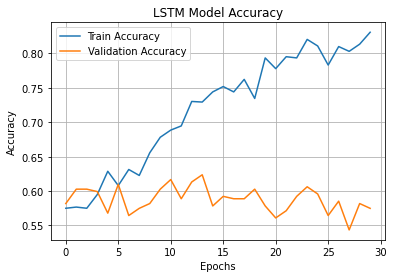

18/18 [==============================] - 6s 231ms/step
Accuracy: 0.5749
Precision: 0.6263
Recall (Sensitivity): 0.7209
F1 Score: 0.6703
AUC-ROC: 0.5560
Specificity: 0.3565
K-score: 0.5749


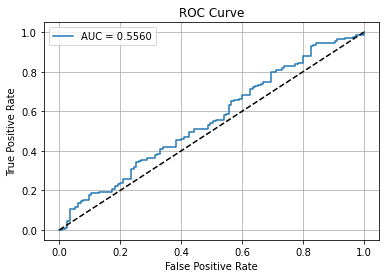

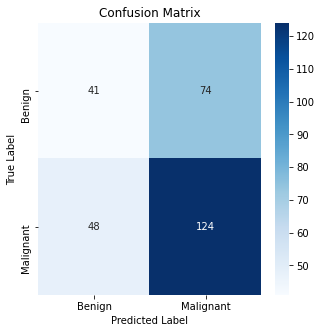

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Set Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 30

# Data Preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory('augmented_images',
                                         target_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE,
                                         class_mode='binary',
                                         subset='training',
                                         shuffle=True)

val_data = datagen.flow_from_directory('augmented_images',
                                       target_size=IMG_SIZE,
                                       batch_size=BATCH_SIZE,
                                       class_mode='binary',
                                       subset='validation',
                                       shuffle=False)

# Build LSTM Model
model = Sequential()
# Reshape image into sequences: (timesteps=224, features=224*3)
model.add(Reshape((IMG_SIZE[0], IMG_SIZE[1]*3), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))

model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS)

# Save Model
model.save('lstm_model.h5')

# Plot Training & Validation Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Get Predictions
y_true = val_data.classes
y_pred_prob = model.predict(val_data)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Compute Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)  # Sensitivity
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)
k_score = (tp + tn) / (tp + tn + fp + fn)  # Kappa Score approximation

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"K-score: {k_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
